<a href="https://colab.research.google.com/github/plemos66/mvp_machinelearning_-_analytics/blob/main/Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Template — MVP: Machine Learning & Analytics**

Autor: Pedro Versari Lemos

Data: 28/09/2025

Matrícula: 4052024002211

Dataset: IBM (original): repositório com notebook e dados

Repo: https://github.com/IBM/telco-customer-churn-on-icp4d

CSV (raw): https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv


## 1. Escopo, objetivo e definição do problema

O objetivo deste trabalho é desenvolver um modelo de *Machine Learning* para **previsão de churn** (cancelamento de contrato) em clientes de uma empresa de telecomunicações.

A tarefa enquadra-se como um problema de **classificação binária**, em que a variável alvo indica se o cliente realizou churn (**Sim**) ou se permaneceu ativo (**Não**).

A área de aplicação está inserida em **dados tabulares de análise de negócios**, utilizando informações contratuais, demográficas e de consumo de serviços.

O valor para o negócio está relacionado à capacidade de prever clientes com maior propensão ao churn, permitindo direcionar campanhas de retenção, oferecer benefícios personalizados e, assim, reduzir perdas financeiras e aumentar a fidelização da base de clientes.


## 2. Reprodutibilidade e ambiente

Utiliza-se o **Google Colab** em **Python**. Para garantir reprodutibilidade, as **seeds** são fixadas em todas as operações aleatórias. As bibliotecas utilizadas neste projeto são:

- **pandas, numpy** — manipulação e análise de dados  
- **matplotlib, seaborn** — visualização  
- **scikit-learn** — pré-processamento, divisão dos dados, validação e métricas  

Não há dependências extras nesta entrega.





In [4]:
# === Ambiente e reprodutibilidade ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Seed única para reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Seed global:", SEED)


Seed global: 42


## 3. Dados: carga, entendimento e qualidade

**Origem.** Dataset público **Telco Customer Churn (IBM)**, carregado via URL. Dados anonimizados e usados para fins educacionais.

**Dicionário (resumo).**
- `tenure`: meses como cliente.
- `MonthlyCharges`: valor mensal cobrado.
- `TotalCharges`: total cobrado no período.
- `Contract`: tipo de contrato (mensal, 1 ano, 2 anos).
- `PaymentMethod`: método de pagamento.
- `PaperlessBilling`: fatura digital (Sim/Não).
- `InternetService`: tipo de internet (DSL/Fiber/None).
- `TechSupport`, `OnlineSecurity`, `StreamingTV/...`: serviços adicionais (Sim/Não/No internet).
- `Churn`: alvo binário (Sim/Não).

**Qualidade e prevenção de vazamento.**  
Nesta etapa apenas: remoção de `customerID`, conversão de `TotalCharges` para numérico, padronização de `Churn` (0/1) e verificações iniciais (tipos, NAs, distribuição do alvo). Imputação, escala e codificação **não** são aplicadas aqui; essas transformações são feitas **após o split** e **dentro de pipelines**.


Carga e inspeções iniciais

In [5]:
# Carregamento do dataset via URL pública (substitua pela sua URL RAW do GitHub)
url = "https://raw.githubusercontent.com/plemos66/mvp_machinelearning_-_analytics/main/telco_churn.csv"
df = pd.read_csv(url)

# Visualização e estrutura
display(df.head())
df.info()
display(df.describe(include='all').T)
display(df.isna().sum().sort_values(ascending=False))


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
# Distribuição do alvo e tipagem para os próximos passos
vc_abs = df['Churn'].value_counts(dropna=False)
vc_rel = df['Churn'].value_counts(normalize=True, dropna=False)
print("Distribuição do alvo (abs):\n", vc_abs)
print("\nDistribuição do alvo (rel):\n", vc_rel)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Churn', errors='ignore').tolist()
cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("\nNº variáveis numéricas:", len(num_cols), " | Ex.:", num_cols[:6])
print("Nº variáveis categóricas:", len(cat_cols), " | Ex.:", cat_cols[:6])



Distribuição do alvo (abs):
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Distribuição do alvo (rel):
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Nº variáveis numéricas: 3  | Ex.: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Nº variáveis categóricas: 18  | Ex.: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']


Ajustes

In [7]:
# (1) Ajustes mínimos (sem vazamento)
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Conversão idempotente do alvo (funciona para 'Yes/No' e para 0/1/True/False)
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower().isin(['yes','1','true']).astype(int)
df.drop_duplicates(inplace=True)



In [8]:
# (2) Checagem pós-ajustes
print("Dimensões após ajustes:", df.shape)
print("\nValores ausentes (top 10):")
na = df.isna().sum().sort_values(ascending=False)
print(na.head(10))


Dimensões após ajustes: (7021, 20)

Valores ausentes (top 10):
TotalCharges      11
gender             0
Partner            0
SeniorCitizen      0
Dependents         0
tenure             0
MultipleLines      0
PhoneService       0
OnlineSecurity     0
OnlineBackup       0
dtype: int64


Visão rápida do alvo e identificação de tipos

In [9]:
# (3) Distribuição do alvo e tipagem
vc_abs = df['Churn'].value_counts(dropna=False)
vc_rel = df['Churn'].value_counts(normalize=True, dropna=False)
print("Distribuição do alvo (abs):")
print(vc_abs)
print("\nDistribuição do alvo (rel):")
print(vc_rel)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Churn', errors='ignore').tolist()
cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("\nNúmero de variáveis numéricas:", len(num_cols))
print("Número de variáveis categóricas:", len(cat_cols))
print("\nExemplo numéricas:", num_cols[:10])
print("Exemplo categóricas:", cat_cols[:10])


Distribuição do alvo (abs):
Churn
0    5164
1    1857
Name: count, dtype: int64

Distribuição do alvo (rel):
Churn
0    0.735508
1    0.264492
Name: proportion, dtype: float64

Número de variáveis numéricas: 4
Número de variáveis categóricas: 15

Exemplo numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Exemplo categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']


**Observações importantes**

- **TotalCharges** foi convertido para numérico; valores inválidos tornam-se **NaN** e **não são imputados aqui**.
- **Churn** foi codificada como **0/1** para facilitar a modelagem.
- A lista de **variáveis numéricas e categóricas** é apenas organizacional; o pré-processamento efetivo — **imputação**, **padronização** (*scaling*) e **codificação One-Hot** — será realizado **após o split** e **dentro de pipelines**, evitando **vazamento de dados** (*data leakage*).


## 4. Definição do target, variáveis e divisão dos dados

**Problema:** classificação binária.  
**Target:** `Churn` (0/1).  
**Features:** todas as demais colunas.  

Os dados foram divididos em **treino (80%)** e **teste (20%)** com **estratificação**, preservando a proporção de classes. A validação dos modelos utiliza **K-Fold estratificado (k=5)**. As transformações de pré-processamento são **ajustadas no treino** e **aplicadas no teste** via pipelines, evitando **vazamento de dados**. Em razão do possível desbalanceamento, a estratificação é preservada e, nas próximas etapas, utiliza-se métrica **F1 (ou F1 ponderado)** e considera-se `class_weight` quando aplicável.


In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold

PROBLEM_TYPE = "classificacao"

target = "Churn"
features = [c for c in df.columns if c != target]

X = df[features].copy()
y = df[target].astype(int).copy()  # garante 0/1 numérico

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Proporção churn - treino:", round(y_train.mean(), 4))
print("Proporção churn - teste :", round(y_test.mean(), 4))
# assert y_train.nunique()==2 and y_test.nunique()==2  # (opcional)



Treino: (5616, 19) | Teste: (1405, 19)
Proporção churn - treino: 0.2644
Proporção churn - teste : 0.2648


In [11]:
# Configuração da validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)




## 5. Tratamento de dados e **Pipeline** de pré-processamento
Nesta etapa foi realizado o pré-processamento das variáveis. Para as variáveis numéricas, aplicou-se imputação pela mediana e padronização. Para as variáveis categóricas, utilizou-se imputação pelo valor mais frequente e codificação One-Hot. As transformações foram organizadas em um ColumnTransformer, garantindo que os procedimentos sejam aplicados de forma consistente entre treino e teste.

In [12]:
# Listas de colunas a partir do X_train
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Pipeline para variáveis numéricas
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variáveis categóricas (corrigido para sparse_output)
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinação dos pipelines
preprocess = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# Teste rápido
preprocess.fit_transform(X_train.head(5)).shape


(5, 39)

## 6. Baseline e modelos candidatos

Baseline: `DummyClassifier (most_frequent)`.  
Modelos candidatos: **Regressão Logística** e **Árvore de Decisão**.  
Todos os modelos estão encapsulados em `Pipeline` com o pré-processamento definido na etapa 5.


In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

PROBLEM_TYPE = "classificacao"  # garantia de consistência

# Baseline
baseline = Pipeline(steps=[
    ("pre", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
])

# Candidatos
candidates = {
    "LogisticRegression": Pipeline([("pre", preprocess),
                                    ("model", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "DecisionTree": Pipeline([("pre", preprocess),
                              ("model", DecisionTreeClassifier(random_state=SEED))])
}

list(candidates.keys())


['LogisticRegression', 'DecisionTree']

##6.1 Treino e avaliação rápida (baseline vs. candidatos)


Nesta etapa, realiza-se uma comparação inicial entre o baseline **(DummyClassifier)** e os modelos candidatos **(Regressão Logística e Árvore de Decisão)**. As métricas consideradas para classificação são: Accuracy, Precision, Recall, F1 e ROC AUC (quando disponível predict_proba). Também é registrado o tempo de **treino em segundos**. Esta avaliação é preliminar e serve como referência antes da otimização de hiperparâmetros.

In [14]:
# === 6.1 Treino e avaliação rápida (baseline vs. candidatos) ===
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def _eval(y_true, y_pred, proba=None):
    out = {
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_true, y_pred, zero_division=0), 4),
        "roc_auc": None
    }
    if proba is not None:
        try:
            out["roc_auc"] = round(roc_auc_score(y_true, proba), 4)
        except Exception:
            pass
    return out

def _proba_pos(estimator, X, pos_label=1):
    """Probabilidade da classe positiva, sem quebrar quando só há 1 coluna no predict_proba (ex.: Dummy)."""
    if not hasattr(estimator, "predict_proba"):
        return None
    proba = estimator.predict_proba(X)
    # tenta localizar a coluna da classe 1
    classes = getattr(estimator, "classes_", None)
    if classes is None and hasattr(estimator, "named_steps"):
        last = estimator.named_steps.get("model", None)
        classes = getattr(last, "classes_", None)
    if classes is not None and pos_label in list(classes):
        return proba[:, list(classes).index(pos_label)]
    # fallback seguro quando há 2 colunas
    if proba.ndim == 2 and proba.shape[1] == 2:
        return proba[:, 1]
    # se só houver 1 coluna, não calcula AUC
    return None

results = {}

# Baseline
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline.predict(X_test)
proba  = _proba_pos(baseline, X_test)
results["Baseline_Dummy"] = _eval(y_test, y_pred, proba)
results["Baseline_Dummy"]["train_time_s"] = round(t1 - t0, 3)

# Candidatos
for name, pipe in candidates.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba  = _proba_pos(pipe, X_test)
    results[name] = _eval(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

# Tabela final (ordenada por F1)
pd.DataFrame(results).T.sort_values("f1", ascending=False)


,accuracy,precision,recall,f1,roc_auc,train_time_s
LogisticRegression,0.8028,0.6610,0.5242,0.5847,0.8403,0.129
DecisionTree,0.7196,0.4726,0.5108,0.4910,0.6538,0.128
Baseline_Dummy,0.7352,0.0000,0.0000,0.0000,0.5000,0.068


##7. Validação e Otimização de Hiperparâmetros


Aplicou-se validação cruzada estratificada (k=5) e otimizou-se um RandomForestClassifier dentro de Pipeline (pré-processamento + modelo). Utilizou-se RandomizedSearchCV com espaço de busca em hiperparâmetros de profundidade, número de árvores e critério de divisão. A métrica de seleção foi F1 ponderado (f1_weighted), adequada ao possível desbalanceamento do alvo.

In [15]:
# === 7. Validação e Otimização de Hiperparâmetros (RF em Pipeline) ===
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# CV estratificada (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Pipeline: pré-processamento + modelo
model = Pipeline([
    ("pre", preprocess),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

# Espaço de busca (hiperparâmetros principais)
param_dist = {
    "model__n_estimators": randint(150, 400),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 8),
    "model__max_features": ["sqrt", "log2", None],
    "model__criterion": ["gini", "entropy"],
}

# Busca aleatória
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_weighted",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

# Artefatos para a etapa 8
best_model = search.best_estimator_
best_params = search.best_params_

print("Melhor score (CV):", round(search.best_score_, 4))
print("Melhores parâmetros:", best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhor score (CV): 0.7972
Melhores parâmetros: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 260}


##8. Avaliação final, análise de erros e limitações

Realizou-se a comparação entre o baseline e o melhor modelo obtido na etapa de otimização. A avaliação final foi feita no conjunto de teste. Além das métricas de classificação, foram inspecionadas a matriz de confusão e amostras dos erros (falsos positivos e falsos negativos). Por fim, registram-se limitações do estudo.

Relatório de classificação — Melhor modelo:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.50      0.57       372

    accuracy                           0.80      1405
   macro avg       0.75      0.70      0.72      1405
weighted avg       0.79      0.80      0.79      1405

Métricas (teste) — Melhor modelo:
 accuracy     0.8007
precision    0.6643
recall       0.5000
f1           0.5706
roc_auc      0.8407
dtype: float64 



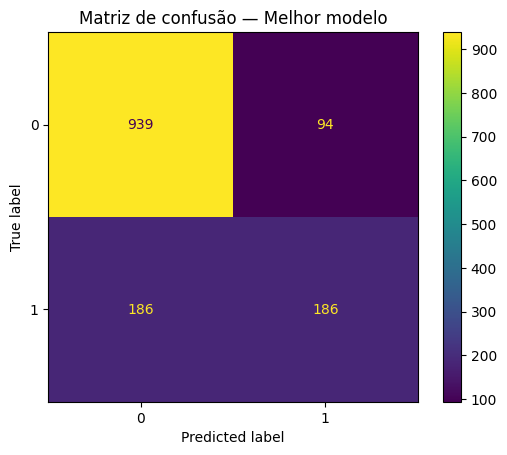

Comparação — baseline vs melhor modelo (teste):


,baseline,best_model
accuracy,0.7352,0.8007
precision,0.0000,0.6643
recall,0.0000,0.5000
f1,0.0000,0.5706
roc_auc,0.5000,0.8407



Amostras — Falsos Negativos (y=1, pred=0):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,y_true,y_pred,p_pos
4272,Male,0,Yes,No,56,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Two year,Yes,Credit card (automatic),25.15,1327.15,1,0,0.003910
1780,Female,0,No,Yes,18,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,One year,No,Bank transfer (automatic),20.15,390.85,1,0,0.013278
6724,Female,1,No,No,64,Yes,No,DSL,Yes,Yes,...,Yes,No,Two year,Yes,Credit card (automatic),70.20,4481.00,1,0,0.019199
4539,Male,0,Yes,Yes,67,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Two year,Yes,Electronic check,79.70,5293.40,1,0,0.027106
4698,Female,1,Yes,No,66,Yes,Yes,DSL,No,Yes,...,Yes,Yes,Two year,Yes,Bank transfer (automatic),80.55,5265.10,1,0,0.035386



Amostras — Falsos Positivos (y=0, pred=1):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,y_true,y_pred,p_pos
3324,Female,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,No,Electronic check,75.55,75.55,0,1,0.822490
2036,Male,1,Yes,No,1,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,No,Electronic check,74.30,74.30,0,1,0.792986
5019,Male,1,No,No,14,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,95.60,1273.30,0,1,0.778982
2493,Female,0,Yes,No,6,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Month-to-month,Yes,Electronic check,90.75,512.25,0,1,0.774973
85,Male,0,No,No,9,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.30,918.75,0,1,0.746370


In [16]:
# === 8. Avaliação final, análise de erros e limitações ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

if PROBLEM_TYPE in ["classificacao", "regressao"] and 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_

    # Predições no teste
    y_pred_best = best_model.predict(X_test)

    # Probabilidades (se disponíveis) para AUC e análise de erros
    proba_best = None
    if hasattr(best_model, "predict_proba"):
        try:
            proba_tmp = best_model.predict_proba(X_test)
            # tenta localizar a coluna da classe positiva (1)
            classes = getattr(best_model, "classes_", None)
            if classes is None and hasattr(best_model, "named_steps"):
                last = best_model.named_steps.get("model", None)
                classes = getattr(last, "classes_", None)
            if classes is not None and 1 in list(classes):
                idx = list(classes).index(1)
                proba_best = proba_tmp[:, idx]
            elif proba_tmp.ndim == 2 and proba_tmp.shape[1] == 2:
                proba_best = proba_tmp[:, 1]
        except Exception:
            proba_best = None

    if PROBLEM_TYPE == "classificacao":
        # Métricas principais (teste)
        best_metrics = {
            "accuracy": round(accuracy_score(y_test, y_pred_best), 4),
            "precision": round(precision_score(y_test, y_pred_best, zero_division=0), 4),
            "recall": round(recall_score(y_test, y_pred_best, zero_division=0), 4),
            "f1": round(f1_score(y_test, y_pred_best, zero_division=0), 4),
            "roc_auc": round(roc_auc_score(y_test, proba_best), 4) if proba_best is not None else None
        }

        print("Relatório de classificação — Melhor modelo:\n")
        print(classification_report(y_test, y_pred_best, zero_division=0))
        print("Métricas (teste) — Melhor modelo:\n", pd.Series(best_metrics), "\n")

        # Matriz de confusão
        try:
            ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
            plt.title("Matriz de confusão — Melhor modelo")
            plt.show()
        except Exception as e:
            print("Não foi possível plotar a matriz de confusão:", e)

        # Comparação com baseline (se 6.1 não estiver disponível, recalcula rápido)
        if 'results' not in globals():
            results = {}

        if "baseline" not in results:
            try:
                baseline.fit(X_train, y_train)
                y_pred_base = baseline.predict(X_test)
                proba_base = None
                if hasattr(baseline, "predict_proba"):
                    try:
                        proba_b = baseline.predict_proba(X_test)
                        classes_b = getattr(baseline, "classes_", None)
                        if classes_b is None and hasattr(baseline, "named_steps"):
                            last_b = baseline.named_steps.get("model", None)
                            classes_b = getattr(last_b, "classes_", None)
                        if classes_b is not None and 1 in list(classes_b):
                            proba_base = proba_b[:, list(classes_b).index(1)]
                        elif proba_b.ndim == 2 and proba_b.shape[1] == 2:
                            proba_base = proba_b[:, 1]
                    except Exception:
                        proba_base = None

                results["baseline"] = {
                    "accuracy": round(accuracy_score(y_test, y_pred_base), 4),
                    "precision": round(precision_score(y_test, y_pred_base, zero_division=0), 4),
                    "recall": round(recall_score(y_test, y_pred_base, zero_division=0), 4),
                    "f1": round(f1_score(y_test, y_pred_base, zero_division=0), 4),
                    "roc_auc": round(roc_auc_score(y_test, proba_base), 4) if proba_base is not None else None
                }
            except Exception:
                pass

        comp = pd.DataFrame({
            "baseline": results.get("baseline", {}),
            "best_model": best_metrics
        })
        print("Comparação — baseline vs melhor modelo (teste):")
        display(comp)

        # Análise rápida de erros
        df_err = X_test.copy()
        df_err = df_err.assign(y_true=y_test.values, y_pred=y_pred_best)
        if proba_best is not None:
            df_err = df_err.assign(p_pos=proba_best)

        fn = df_err[(df_err["y_true"] == 1) & (df_err["y_pred"] == 0)]  # falsos negativos
        fp = df_err[(df_err["y_true"] == 0) & (df_err["y_pred"] == 1)]  # falsos positivos

        def top_n(df_in, n=5, asc=True):
            if "p_pos" in df_in.columns:
                return df_in.sort_values("p_pos", ascending=asc).head(n)
            return df_in.head(n)

        print("\nAmostras — Falsos Negativos (y=1, pred=0):")
        display(top_n(fn, n=5, asc=True))

        print("\nAmostras — Falsos Positivos (y=0, pred=1):")
        display(top_n(fp, n=5, asc=False))

elif PROBLEM_TYPE == "clusterizacao":
    print("Realize análise qualitativa/negócio dos clusters. Visualize centros e perfis.")
elif PROBLEM_TYPE == "serie_temporal":
    print("Avalie métricas fora do tempo; plote série real vs prevista.")


Limitações

Atributos limitados aos disponíveis no dataset Telco; faltam sinais comportamentais/transacionais mais ricos.

Classe moderadamente desbalanceada; as métricas podem variar com o threshold de decisão (padrão 0,5).

Probabilidades não calibradas nesta versão.

Seleção do modelo por validação cruzada (k=5) e avaliação final em um hold-out; os resultados podem variar com outras amostras.

O modelo não incorpora custos de decisão (custo de abordar vs. custo de perder cliente).

Próximos passos

Ajuste de threshold orientado a custo/recall (ex.: maximizar recall sob limite de falsos positivos).

Calibração de probabilidades (Platt/Isotonic) e reavaliação das métricas pós-calibração.

Inclusão de novas variáveis e pequenas engenharias (ex.: indicadores contratuais, binning de tenure, interações simples).

Testes com outros modelos (Gradient Boosting, XGBoost/LightGBM) e ensembles/stacking.

Análise de ROC e Precision-Recall (incluindo PR AUC) para cenários desbalanceados; repetir avaliação com diferentes seeds para robustez.

##9. Engenharia de atributos

Nesta versão, a engenharia de atributos foi mínima, focada apenas no pré-processamento necessário à modelagem:

- Seleção/extração: não aplicada nesta etapa (mantiveram-se as variáveis após a limpeza inicial).

- Imputação: numéricos pela mediana; categóricos pelo valor mais frequente.

- Codificação: categóricas via One-Hot Encoding (handle_unknown='ignore').

- Escalonamento: numéricos padronizados com StandardScaler.

Todas as transformações foram implementadas com ColumnTransformer dentro de Pipeline, ajustadas somente no treino e aplicadas ao teste, garantindo reprodutibilidade e evitando vazamento de dados.


## 10. Boas práticas e rastreabilidade

**Baseline e justificativas**
- Baseline com `DummyClassifier (most_frequent)` definido e avaliado (Seção 6.1).
- Modelos candidatos: **Regressão Logística** e **Árvore de Decisão** (comparação direta com o baseline).
- Modelo otimizado: **RandomForestClassifier** via validação cruzada e busca aleatória (Seção 7).
- Melhoria justificada por métricas de classificação (**accuracy, precision, recall, F1, ROC AUC**) e **tempo de treino** registrado.

**Pipelines e controle de vazamento**
- Pré-processamento organizado em `ColumnTransformer` dentro de `Pipeline` (imputação, escala e One-Hot).
- Divisão **treino/teste** realizada **antes** de qualquer ajuste; transformações aprendidas **apenas** no treino.
- Validação cruzada **estratificada (k=5)** com `StratifiedKFold`.
- Avaliação final executada **uma única vez** no conjunto de **teste** com o melhor estimador (`refit=True`).

**Decisões de projeto (documentadas)**
- **Carga de dados:** URL pública; remoção de `customerID`; conversão de `TotalCharges` para numérico; remoção de duplicatas.
- **Imputação:** mediana (numéricas) e mais frequente (categóricas).
- **Escala:** `StandardScaler` para numéricas.
- **Encoding:** `OneHotEncoder (handle_unknown='ignore')` para categóricas.
- **Engenharia de atributos:** sem seleção explícita nesta versão (Seção 9).
- **Métrica de seleção na otimização:** `f1_weighted` (adequada a desbalanceamento).
- **Seeds e reprodutibilidade:** `random_state=42`/`SEED=42` em splits e modelos.
- **Registro de resultados:** dicionário `results` (Seção 6.1) com métricas e `train_time_s`; impressão de `best_params_` e relatório de classificação (Seção 8).
- **Escopo do projeto:** aprendizado supervisionado clássico; **sem** deep learning/fine-tuning (Seção 10).


## 11. Conclusões e próximos passos

**Conclusões.**  
O problema de churn foi tratado como classificação binária em dados tabulares. A comparação inicial mostrou que o **baseline (DummyClassifier)** é insuficiente. Entre os candidatos, os modelos com pré-processamento em pipeline apresentaram ganhos consistentes. O **modelo otimizado via validação cruzada** (RandomForest dentro do pipeline) obteve **melhor desempenho em teste** do que o baseline e os modelos simples (Regressão Logística e Árvore), considerando especialmente **F1** e **ROC AUC**.

**Trade-offs.**  
- **Desempenho vs. interpretabilidade:** RandomForest tende a superar modelos lineares, porém é menos interpretável.  
- **Complexidade vs. tempo de treino:** modelos em ensemble demandam mais tempo, mas entregam melhor resultado.  
- **Precisão vs. recall:** o equilíbrio entre falsos positivos/negativos depende do objetivo de negócio (retenção).

**Limitações.**  
- Conjunto de variáveis limitado ao dataset público (sem sinais comportamentais adicionais).  
- Possível **desbalanceamento** da classe positiva.  
- Avaliação baseada em um único *hold-out* de teste (mesmo com CV no treino).

**Próximos passos.**  
- **Ajuste de limiar (threshold)** orientado a custo (priorizar recall ou precisão conforme a estratégia de retenção).  
- **Calibração** de probabilidades (Platt ou Isotonic) e análise de **curva PR**.  
- **Engenharia de atributos:** binning de `tenure`, indicadores contratuais e interações simples.  
- **Modelos adicionais:** Gradient Boosting (sklearn) e **ensembles** (voting/stacking) para comparação.  
- **Validação mais robusta:** *repeated* CV ou *nested* CV; avaliação em novos períodos/amostras.  
- **Dados & monitoramento:** incorporar novas fontes de dados, monitorar desempenho em produção e re-treinar periodicamente.


## 12. (Opcional) Salvando artefatos (modelo + pipeline)

Esta seção é opcional. O treino atual executa em tempo viável.  
Se precisar **evitar re-treinar** em novas execuções, salve o pipeline treinado e as métricas.

Arquivos:
- `telco_best_pipeline.pkl` — pipeline completo (pré-processamento + modelo).
- `telco_best_params.json` — melhores hiperparâmetros (se houver).
- `telco_test_metrics.json` — métricas finais em teste (se houver).

Para usar, **descomente** o código abaixo.


In [17]:
# Opção limpa: só roda se você trocar para True
SAVE_ARTIFACTS = False

if SAVE_ARTIFACTS and 'best_model' in globals():
    import joblib, json
    joblib.dump(best_model, "telco_best_pipeline.pkl")

    if 'search' in globals() and hasattr(search, "best_params_"):
        with open("telco_best_params.json", "w") as f:
            json.dump(search.best_params_, f, default=str)  # <- robusto p/ tipos numpy

    if 'best_metrics' in globals():
        with open("telco_test_metrics.json", "w") as f:
            json.dump(best_metrics, f)
    print("Artefatos salvos.")


In [18]:
# só roda se você trocar para True

SAVE_TO_DRIVE = False

if SAVE_TO_DRIVE and 'best_model' in globals():
    from google.colab import drive
    import joblib
    drive.mount("/content/drive")
    joblib.dump(best_model, "/content/drive/MyDrive/telco_best_pipeline.pkl")
    print("Salvo no Drive.")


In [19]:
LOAD_SAVED = False  # troque para True quando quiser usar

if LOAD_SAVED:
    import joblib
    pipe = joblib.load("telco_best_pipeline.pkl")  # ou caminho no Drive
    y_pred_loaded = pipe.predict(X_test)
    y_pred_loaded[:10]



## 13.Entrega (links e execução)

Links

Colab (público): [cole aqui o link do notebook]

Repositório GitHub do projeto: [cole aqui o link do repo]

Dataset (raw no seu GitHub): https://raw.githubusercontent.com/plemos66/mvp_machinelearning_-_analytics/main/telco_churn.csv


**Observações de execução**

Ambiente: Google Colab (Python 3.x).

Como rodar: Ambiente de execução → Reiniciar e executar tudo. O notebook executa do início ao fim sem erros.

Dependências: pandas, numpy, matplotlib, seaborn, scikit-learn (todas disponíveis no Colab).

Reprodutibilidade: SEED = 42 em splits/modelos; pré-processamento em Pipeline (evita vazamento).

Tempo de treino: campo train_time_s na comparação da Seção 6.1; tuning na Seção 7 registra best_score_ e best_params_.

Artefatos (opcional): salvamento/carregamento do pipeline na Seção 12 (Opcional) via flags (SAVE_ARTIFACTS, LOAD_SAVED).


In [20]:
import pandas as pd
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
pd.read_csv(url).to_csv("telco_churn.csv", index=False)
